## Different approaches towards Bayesian Optimization in pyGPGO
#### by José Jiménez (Oct 18, 2017)

One of the most attractive characteristics of the Bayesian Optimization framework is the amount of choices one has when designing the optimizer. Among these choices, we can include:

* Surrogate models
* Covariance function
* Acquisition behaviour
* Statistical approach towards covariance hyperparameter treatment.

All of these are covered to a large extent in `pyGPGO`, making it, to the best of my knowledge the most comprehensive open-source BO package.

In this tutorial, we will cover some of the offered possibilities when treating covariance function hyperparameters: the marginal likelihood approach and the full-bayesian approach.

We pick Franke's function as our optimization target:

In [1]:
import numpy as np

def f(x, y):
    # Franke's function (https://www.mathworks.com/help/curvefit/franke.html)
    one = 0.75 * np.exp(-(9 * x - 2)**2/4 - (9 * y - 2)**2/4)
    two = 0.75 * np.exp(-(9 * x + 1)**2/49 - (9 * y + 1)/10)
    three = 0.5 * np.exp(-(9 * x - 7)**2/4 - (9*y - 3)**2/4)
    four = 0.25 * np.exp(-(9 * x - 4)**2 - (9*y - 7)**2)
    return one + two + three - four

A simple visualization of the latter:

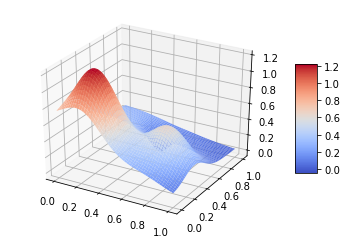

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

x = np.linspace(0, 1, num=1000)
y = np.linspace(0, 1, num=1000)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

### The empirical Bayes approach (marginal log-likelihood)

We use the Matérn $\nu=3/2$ as our covariance function, a Gaussian Process surrogate and the expected improvement acquisition function. Notice we call the `GaussianProcess` class with arguments `optimize=True` and `usegrads=True`, which specifies that we want to optimize the marginal log-likelihood using exact gradients (`usegrads=False` would approximate them).

In [3]:
from pyGPGO.covfunc import matern32
from pyGPGO.acquisition import Acquisition
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.GPGO import GPGO

cov = matern32()
gp = GaussianProcess(cov, optimize=True, usegrads=True)
acq = Acquisition(mode='ExpectedImprovement')
param = {'x': ('cont', [0, 1]),
         'y': ('cont', [0, 1])}

We start the opimization process as usual and get our results back:

In [4]:
np.random.seed(20)
gpgo = GPGO(gp, acq, f, param)
gpgo.run(max_iter=10)

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.5881308   0.89771373]. 	  0.12055515791243088 	 0.35562010326493304
init   	 [ 0.89153073  0.81583748]. 	  0.06525608955367107 	 0.35562010326493304
init   	 [ 0.03588959  0.69175758]. 	  0.35562010326493304 	 0.35562010326493304
1      	 [ 0.          0.25915187]. 	  0.794989415863 	 0.794989415863
2      	 [ 0.  0.]. 	  0.766420591285 	 0.794989415863
3      	 [ 0.21196786  0.12664915]. 	  1.13190171375 	 1.13190171375
4      	 [ 0.42444811  0.05313551]. 	  0.594450291036 	 1.13190171375
5      	 [ 0.13621546  0.04317405]. 	  0.927350710805 	 1.13190171375
6      	 [ 0.2018102  0.1964748]. 	  1.21785383311 	 1.21785383311
7      	 [ 0.25101389  0.26671161]. 	  1.13997169798 	 1.21785383311
8      	 [ 0.1806952   0.22188891]. 	  1.20734970931 	 1.21785383311
9      	 [ 0.21054723  0.2134485 ]. 	  1.21930124867 	 1.21930124867
10     	 [ 0.22012822  0.20016475]. 	  1.21596707026 	 1.21930124867


In [5]:
gpgo.getResult()

(OrderedDict([('x', 0.2105472346440575), ('y', 0.21344849591604545)]),
 1.2193012486738231)

### The full Bayesian approach (via MCMC sampling)

Instead of optimizing the marginal log-likelihood, a Bayesian would take into account the uncertainty of the parameters in the optimization procedure by integrating them. The process here is very similar, but in this case we change our `GaussianProcess` class by another that implements MCMC sampling (via `pyMC3`). We use slice sampling in this example for 300 iterations using a burnin of 100 samples. 

In [6]:
from pyGPGO.surrogates.GaussianProcessMCMC import GaussianProcessMCMC
import pymc3 as pm

gp = GaussianProcessMCMC(cov, niter=300, burnin=100, step=pm.Slice)
acq = Acquisition(mode='IntegratedExpectedImprovement')

The procedure now is exactly the same as before:

In [7]:
np.random.seed(20)
gpgo = GPGO(gp, acq, f, param)
gpgo.run(max_iter=10)

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.


100%|██████████| 800/800 [00:03<00:00, 200.42it/s]


init   	 [ 0.5881308   0.89771373]. 	  0.12055515791243088 	 0.35562010326493304
init   	 [ 0.89153073  0.81583748]. 	  0.06525608955367107 	 0.35562010326493304
init   	 [ 0.03588959  0.69175758]. 	  0.35562010326493304 	 0.35562010326493304


100%|██████████| 800/800 [00:03<00:00, 204.23it/s]


1      	 [ 0.  0.]. 	  0.766420591285 	 0.766420591285


100%|██████████| 800/800 [00:04<00:00, 197.40it/s]


2      	 [  5.88102607e-07   0.00000000e+00]. 	  0.766420984882 	 0.766420984882


100%|██████████| 800/800 [00:04<00:00, 181.14it/s]


3      	 [ 0.00785002  0.09755702]. 	  0.823101576252 	 0.823101576252


100%|██████████| 800/800 [00:04<00:00, 190.07it/s]


4      	 [  7.90622565e-07   0.00000000e+00]. 	  0.766421120422 	 0.823101576252


100%|██████████| 800/800 [00:04<00:00, 186.54it/s]


5      	 [ 0.00602414  0.07486487]. 	  0.807695279731 	 0.823101576252


100%|██████████| 800/800 [00:04<00:00, 194.40it/s]


6      	 [ 0.00701943  0.08723257]. 	  0.816090107048 	 0.823101576252


100%|██████████| 800/800 [00:04<00:00, 190.72it/s]


7      	 [ 0.22450805  0.07187454]. 	  1.00278527461 	 1.00278527461


100%|██████████| 800/800 [00:04<00:00, 186.33it/s]


8      	 [ 0.18505996  0.07038517]. 	  1.0083553858 	 1.0083553858


100%|██████████| 800/800 [00:04<00:00, 180.27it/s]


9      	 [ 0.19979389  0.11596879]. 	  1.11198313786 	 1.11198313786


100%|██████████| 800/800 [00:04<00:00, 179.73it/s]


10     	 [ 0.20354927  0.09534183]. 	  1.06653780872 	 1.11198313786


We can check the posterior distribution of the hyperparameters $\theta$:

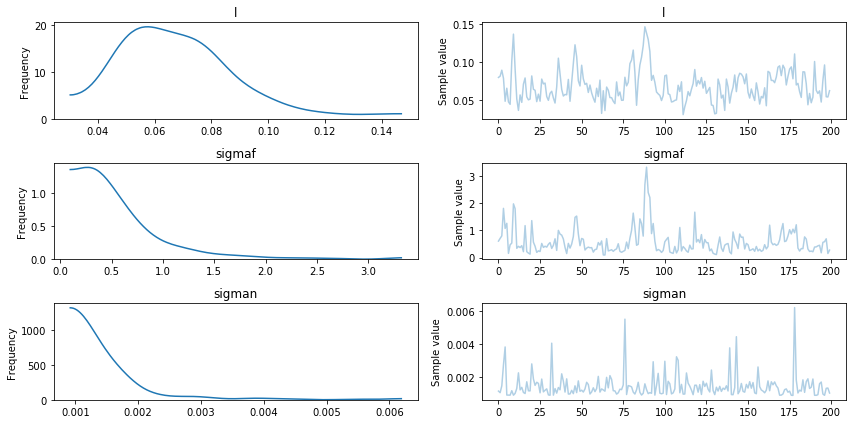

In [8]:
gpgo.GP.posteriorPlot()

And finally get our results back:

In [9]:
gpgo.getResult()

(OrderedDict([('x', 0.19979389426404875), ('y', 0.11596878567120184)]),
 1.1119831378622227)